# Producing multiple peaked synthetic profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  
 
To construct multiple peaked events, we need to consider:  
 1) The rainfall volume$ V_1,...V_N$ for each peak. Suggestion: use $V/N$, so we have the same total rainfall.  
 2) The shape of each peak. Suggestion: use the same shape, but different peak rainfall height so it gives the desired volume  given a start-to-end duration for the peak.  
 3) The start-to-end duration of each peak. This is a parameter we can play with, but probably we will mainly look at short durations.  
 4) The spacing between peaks. Here, the question is what a "fair" spacing for comparison so that the overall "event duration" is the same, and this is probably a bit subjective. We could also consider this as another parameter to play with.  
 


In [1]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [7]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
colors = ['black', 'gold', 'darkred', 'cadetblue', 'darksalmon']
duration = '6h'
N_subpeaks= 3
default_peak_shape='refh2-summer'
total_mm_accum=59.29
total_duration_minutes = (int(duration[0]) * 60) +1
subpeak_duration_minutes=total_duration_minutes/6
peak_before_frac = 0.5

# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 

if total_duration_minutes == (int(duration[0]) * 60) +1:
    seconds = (end - start).total_seconds() + 61
else:    
    seconds = (end - start).total_seconds() + 60 
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))       

### Create dataframe for one method containing the accumulation and rate at each minute of time

In [6]:
# For each method produce a dataframe containing precipitation values for each minute and save these to file
for method in methods:
    print(method, duration)

    # Find accumulation and rate
    accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
    # Create as dataframe
    accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
    # Keep only columns needed for feeding to ReFH2
    accum_df = accum_df[['Dates','Rate (mm/min)']]
    # Write to csv
    accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_{}.csv".format(duration,duration, method),
                   header = False, index = False)
#         print(accum_df['Rate (mm/min)'].max())

single-peak 6h
divide-time 6h
max-spread 6h
subpeak-timing 6h


## Plot pre loss removal profiles

In [10]:
methods=['6h_single-peak','6h_divide-time','6h_max-spread','6h_subpeak-timing']

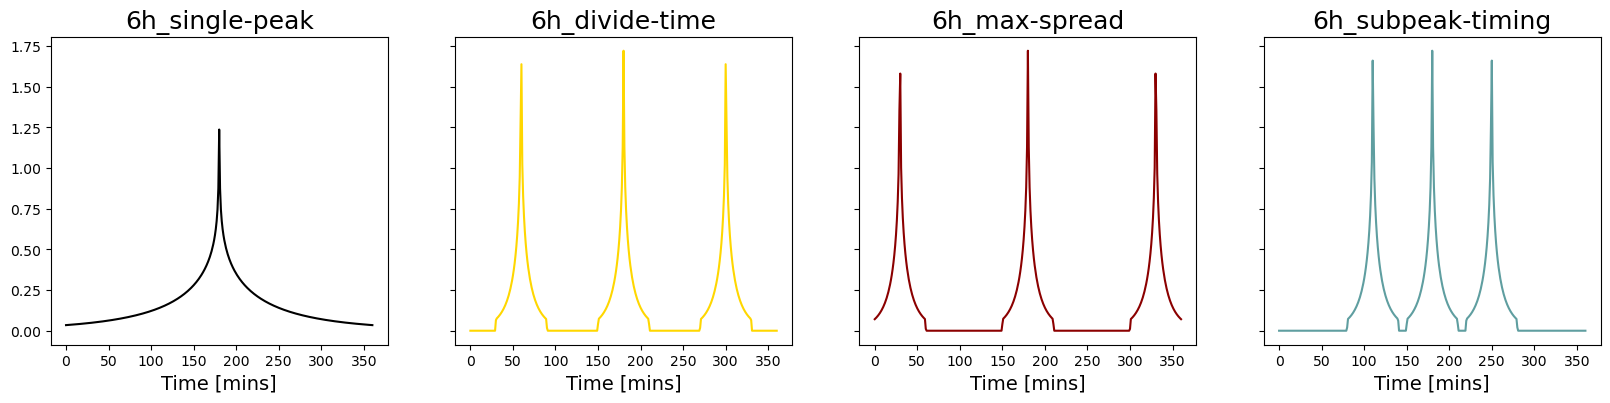

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,4), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_prelossremoval(ax, methods[number], total_duration_minutes, "../SyntheticProfiles/", colors[number])

# Plot post loss removal profiles

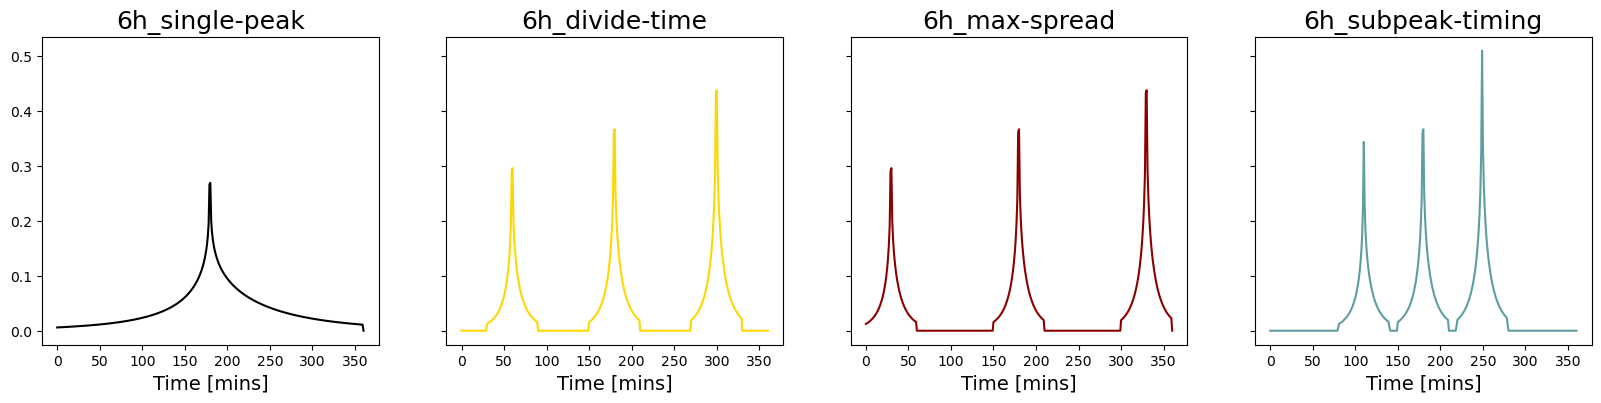

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,4), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_postlossremoval(ax, methods[number],total_duration_minutes,"../SyntheticProfiles/", colors[number])

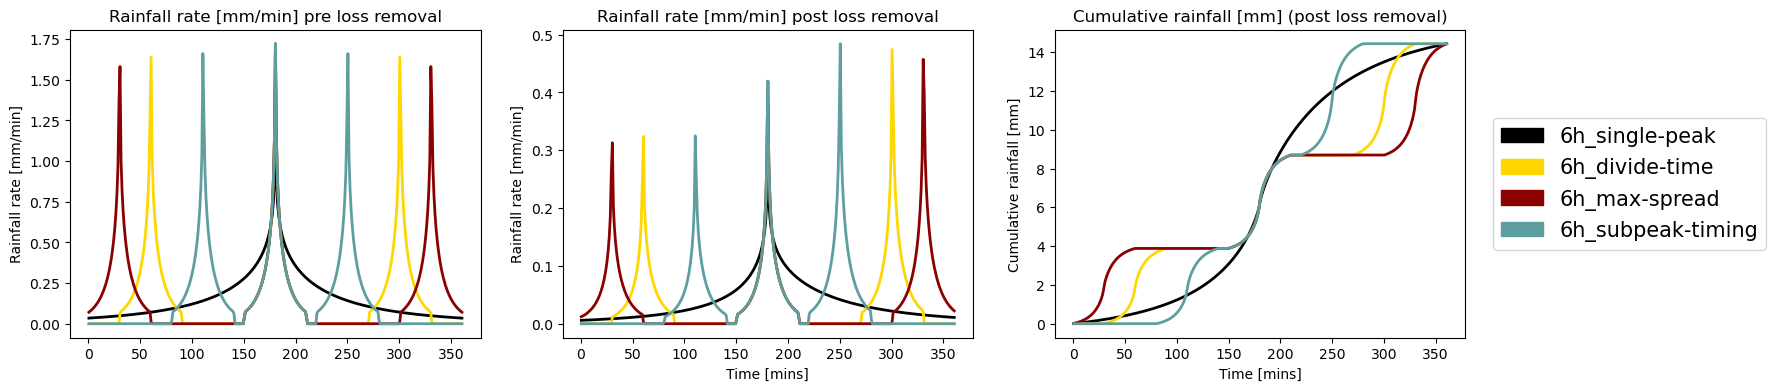

In [19]:
fig, axes = plt.subplots(1, 3,figsize=(18,4), sharex =True, sharey = False)
for axes_number, method in enumerate(methods):
  
    pre_loss_removal = pd.read_csv("6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv("6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    
    # Reformat
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    
    # Plot pre loss removal rainfall rate
    axes[0].plot(np.array(range(total_duration_minutes))+0.5,pre_loss_removal['Rainfall'], color=colors[axes_number], linewidth = 2)   
    axes[0].set_ylabel('Rainfall rate [mm/min]')
    axes[0].set_title('Rainfall rate [mm/min] pre loss removal')
    
    # Plot post loss removal rainfall rate
    axes[1].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=colors[axes_number], linewidth = 2)   
    axes[1].set_xlabel('Time [mins]')
    axes[1].set_ylabel('Rainfall rate [mm/min]')
    axes[1].set_title('Rainfall rate [mm/min] post loss removal')
    
    # Plot cumulative rainfall rate
    axes[2].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['cumulative_rainfall_this_min'], color=colors[axes_number], linewidth = 2)   
    axes[2].set_xlabel('Time [mins]')
    axes[2].set_ylabel('Cumulative rainfall [mm]')
    axes[2].set_title('Cumulative rainfall [mm] (post loss removal)')
    
    
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(methods[i]) ) for i in range(len(methods)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.4, 0.5), loc='center', ncol=1, prop={'size': 15} );    